## GreenDetect - Proyecto Final
CNN para identificar patologías en las hojas de las plantas

In [1]:
!pip install -q kaggle

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from collections import Counter

# TensorFlow y Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Scikit-learn para métricas
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import class_weight

import warnings
warnings.filterwarnings('ignore')

In [3]:
os.makedirs('/root/.kaggle', exist_ok=True)

with open('/root/.kaggle/kaggle.json', 'w') as f:
    f.write('{"username":"nahomycastro","key":"e239a26cabfe03bd08a607337453ce27"}')

In [4]:
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d kanishk3813/pathogen-dataset
!unzip -q pathogen-dataset.zip -d pathogen_data

Dataset URL: https://www.kaggle.com/datasets/kanishk3813/pathogen-dataset
License(s): apache-2.0
 92% 1.31G/1.43G [00:08<00:03, 38.0MB/s]
100% 1.43G/1.43G [00:08<00:00, 180MB/s] 


### Análisis exploratorio de los datos

In [5]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 8)

In [6]:
data_dir = 'pathogen_data/pathogen'

In [7]:
print("--- Estructura del dataset ---")

for root, dirs, files in os.walk(data_dir):
    level = root.replace(data_dir, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 2 * (level + 1)
    if level < 2:
        for file in files[:3]:
            print(f'{subindent}{file}')
        if len(files) > 3:
            print(f'{subindent}... y {len(files) - 3} archivos más')

--- Estructura del dataset ---
pathogen/
  Virus/
    enhanced_image_2207.jpg
    enhanced_image_2361.jpg
    image_2482.jpg
    ... y 7996 archivos más
  Healthy/
    Healthy2278.jpg
    Healthy2391.jpg
    Healthy5384.jpg
    ... y 7997 archivos más
  Fungi/
    image_6352.jpg
    image_2829.jpg
    image_5818.jpg
    ... y 7997 archivos más
  Bacteria/
    Bacteria_original_enhanced_image_309.jpg_8a585793-0d78-4369-acec-9889c4bb046a.jpg
    enhanced_enhanced_image_1603.jpg
    enhanced_image_1663.jpg
    ... y 7996 archivos más
  Pests/
    enhanced_image_2207.jpg
    enhanced_image_2361.jpg
    image_2482.jpg
    ... y 7996 archivos más


In [8]:
def contar_imagenes_por_clase(directorio):
    """
    Cuenta las imágenes en cada subdirectorio (clase)
    """
    clases_info = {}

    for clase in os.listdir(directorio):
        clase_path = os.path.join(directorio, clase)
        if os.path.isdir(clase_path):
            imagenes = [f for f in os.listdir(clase_path)
                       if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
            clases_info[clase] = len(imagenes)

    return clases_info

In [9]:
clases_dict = contar_imagenes_por_clase(data_dir)

In [10]:
df_clases = pd.DataFrame(list(clases_dict.items()),
                         columns=['Clase', 'Cantidad_Imagenes'])
df_clases = df_clases.sort_values('Cantidad_Imagenes', ascending=False)

print("\n--- Distribución de imágenes por clase ---\n")
print(df_clases.to_string(index=False))
print(f"\nTotal de imágenes: {df_clases['Cantidad_Imagenes'].sum()}")
print(f"Total de clases: {len(df_clases)}")


--- Distribución de imágenes por clase ---

   Clase  Cantidad_Imagenes
 Healthy               8000
   Fungi               8000
   Virus               7999
Bacteria               7999
   Pests               7999

Total de imágenes: 39997
Total de clases: 5


In [11]:
def analizar_dimensiones_imagenes(directorio, muestra=None):
    """
    Analiza las dimensiones y propiedades de una muestra de imágenes
    """
    dimensiones = []
    aspectos = []
    tamaños_kb = []
    formatos = []

    total_procesadas = 0

    for clase in os.listdir(directorio):
        clase_path = os.path.join(directorio, clase)
        if os.path.isdir(clase_path):
            imagenes = [f for f in os.listdir(clase_path)
                       if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]

            muestra_clase = min(muestra // len(os.listdir(directorio)), len(imagenes))

            for img_name in imagenes[:muestra_clase]:
                try:
                    img_path = os.path.join(clase_path, img_name)
                    img = Image.open(img_path)

                    width, height = img.size
                    dimensiones.append((width, height))
                    aspectos.append(width / height)
                    tamaños_kb.append(os.path.getsize(img_path) / 1024)
                    formatos.append(img.format)

                    total_procesadas += 1
                    img.close()
                except Exception as e:
                    continue

    return dimensiones, aspectos, tamaños_kb, formatos, total_procesadas

print("Analizando dimensiones de imágenes...")
dimensiones, aspectos, tamaños_kb, formatos, total = analizar_dimensiones_imagenes(data_dir, muestra=39997)

# Crear DataFrame con la información
df_dims = pd.DataFrame({
    'Ancho': [d[0] for d in dimensiones],
    'Alto': [d[1] for d in dimensiones],
    'Aspecto': aspectos,
    'Tamaño_KB': tamaños_kb,
    'Formato': formatos
})

print(f"\n --- Análisis de {total} imágenes ---\n")
print("\nEstadísticas de dimensiones:")
print(df_dims[['Ancho', 'Alto', 'Aspecto', 'Tamaño_KB']].describe())

print("\nFormatos encontrados:")
print(Counter(formatos))

# Encontrar dimensiones únicas
dims_unicas = set(dimensiones)
print(f"\nDimensiones únicas encontradas: {len(dims_unicas)}")
if len(dims_unicas) <= 10:
    print("Dimensiones más comunes:")
    for dim, count in Counter(dimensiones).most_common(5):
        print(f"   {dim[0]}x{dim[1]}: {count} imágenes")

Analizando dimensiones de imágenes...

 --- Análisis de 39995 imágenes ---


Estadísticas de dimensiones:
             Ancho         Alto  Aspecto     Tamaño_KB
count  39995.00000  39995.00000  39995.0  39995.000000
mean     460.80000    460.80000      1.0     37.593015
std      102.40128    102.40128      0.0     12.911216
min      256.00000    256.00000      1.0      6.251953
25%      512.00000    512.00000      1.0     28.711914
50%      512.00000    512.00000      1.0     37.969727
75%      512.00000    512.00000      1.0     46.126465
max      512.00000    512.00000      1.0    112.418945

Formatos encontrados:
Counter({'JPEG': 39995})

Dimensiones únicas encontradas: 2
Dimensiones más comunes:
   512x512: 31996 imágenes
   256x256: 7999 imágenes


Mostrando muestras de cada clase...


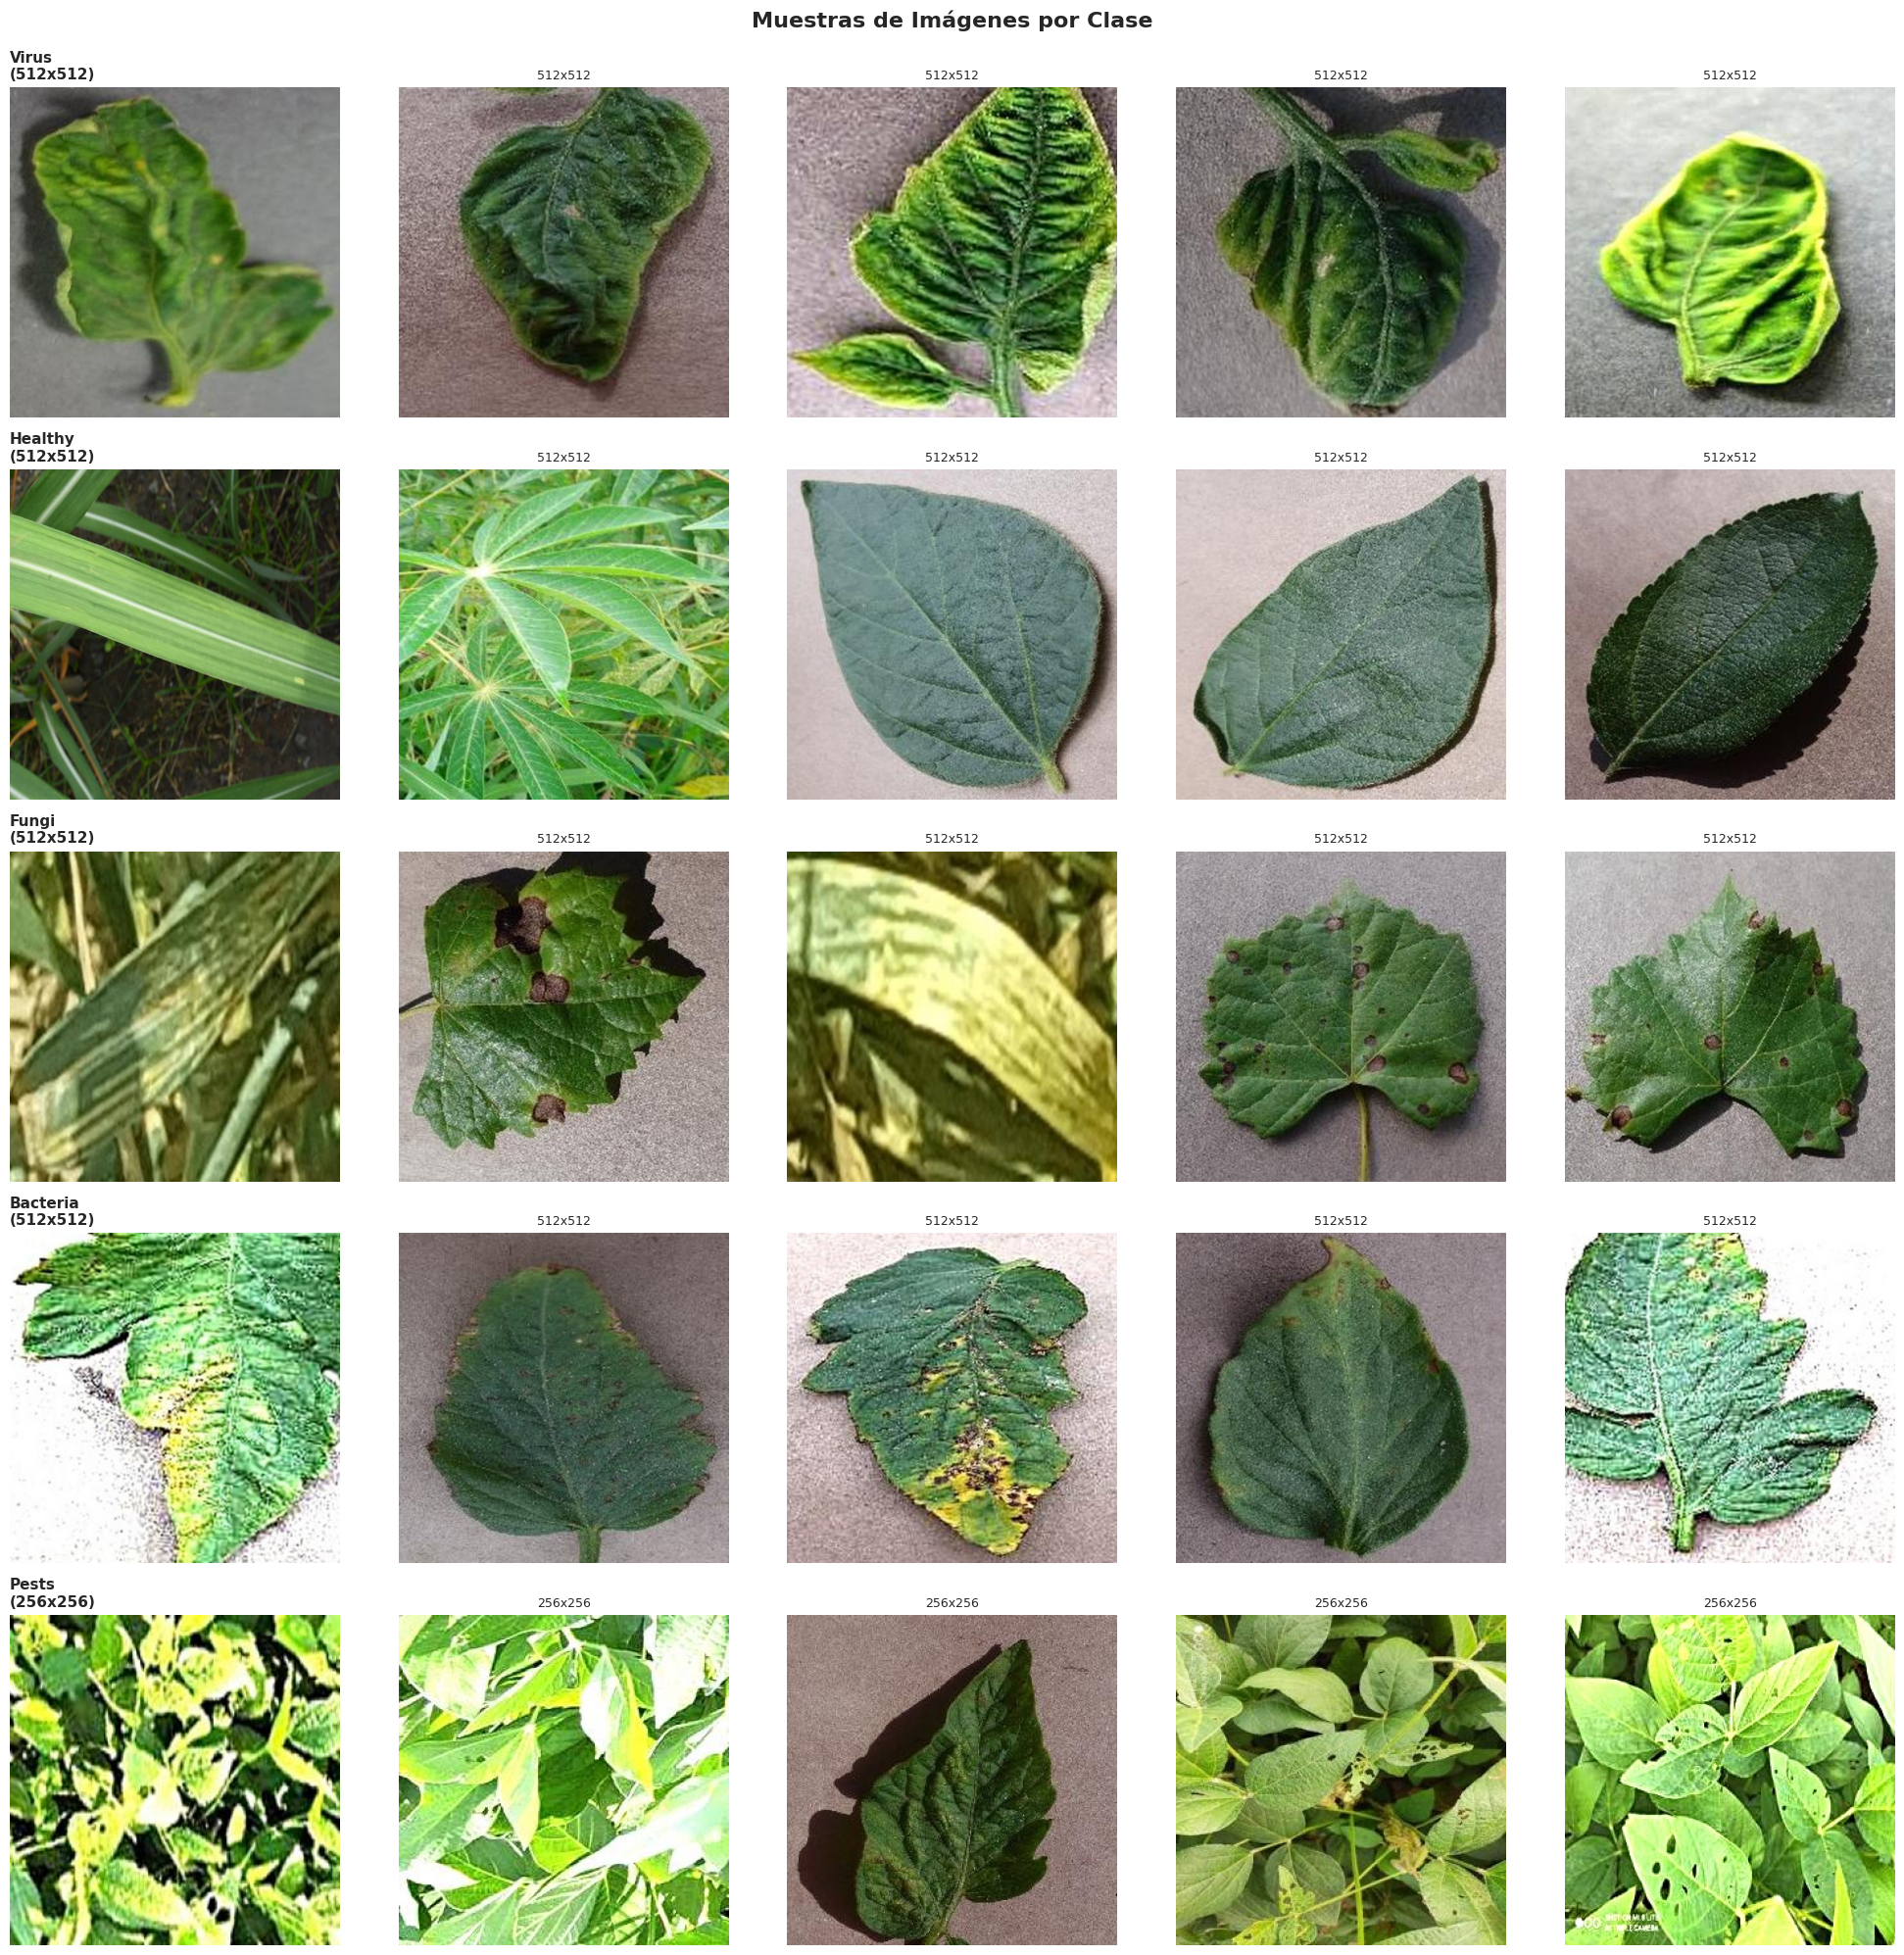

In [12]:
def mostrar_muestras_por_clase(directorio, muestras_por_clase=4):
    """
    Muestra imágenes de ejemplo de cada clase
    """
    clases = [d for d in os.listdir(directorio)
              if os.path.isdir(os.path.join(directorio, d))]

    n_clases = len(clases)
    fig, axes = plt.subplots(n_clases, muestras_por_clase,
                             figsize=(muestras_por_clase * 4, n_clases * 4))

    if n_clases == 1:
        axes = axes.reshape(1, -1)

    for i, clase in enumerate(clases):
        clase_path = os.path.join(directorio, clase)
        imagenes = [f for f in os.listdir(clase_path)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]

        # Seleccionar muestras aleatorias
        muestras = np.random.choice(imagenes,
                                    min(muestras_por_clase, len(imagenes)),
                                    replace=False)

        for j, img_name in enumerate(muestras):
            img_path = os.path.join(clase_path, img_name)
            img = plt.imread(img_path)

            axes[i, j].imshow(img)
            axes[i, j].axis('off')

            if j == 0:
                axes[i, j].set_title(f'{clase}\n({img.shape[0]}x{img.shape[1]})',
                                    fontsize=11, fontweight='bold', loc='left')
            else:
                axes[i, j].set_title(f'{img.shape[0]}x{img.shape[1]}',
                                    fontsize=9)

    plt.suptitle('Muestras de Imágenes por Clase',
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

print("Mostrando muestras de cada clase...")
mostrar_muestras_por_clase(data_dir, muestras_por_clase=5)

### Elaboración de modelo CNN tradicional

#### Configuración de parámetros

In [13]:
np.random.seed(7969)
tf.random.set_seed(7969)

In [14]:
print("Librerías importadas correctamente")
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU disponible: {tf.config.list_physical_devices('GPU')}")

Librerías importadas correctamente
TensorFlow version: 2.19.0
GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [15]:
DATA_DIR = 'pathogen_data/pathogen'
OUTPUT_DIR = 'output_cnn'
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [16]:
IMG_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 15
LEARNING_RATE = 0.001

In [17]:
CLASSES = ['Bacteria', 'Fungi', 'Healthy', 'Pests', 'Virus']
NUM_CLASSES = len(CLASSES)

In [18]:
print("--- Configuración del modelo ---\n")
print(f"   Tamaño de imagen: {IMG_SIZE}x{IMG_SIZE}")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Épocas: {EPOCHS}")
print(f"   Learning rate: {LEARNING_RATE}")
print(f"   Clases: {CLASSES}")
print(f"   Número de clases: {NUM_CLASSES}")

--- Configuración del modelo ---

   Tamaño de imagen: 256x256
   Batch size: 32
   Épocas: 15
   Learning rate: 0.001
   Clases: ['Bacteria', 'Fungi', 'Healthy', 'Pests', 'Virus']
   Número de clases: 5


#### Generadores de datos con Data Augmentation

In [19]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3,
    horizontal_flip=True,        # Flip horizontal
    vertical_flip=True,          # Flip vertical
    brightness_range=[0.8, 1.2], # Variación de brillo
    zoom_range=0.05,             # Zoom mínimo
    fill_mode='reflect'
)

In [20]:
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3
)

In [21]:
print("Creando generadores de datos...")

train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

validation_generator = val_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=42
)

print("\nGeneradores creados:")
print(f"   Imágenes de entrenamiento: {train_generator.samples}")
print(f"   Imágenes de validación: {validation_generator.samples}")
print(f"   Clases encontradas: {train_generator.class_indices}")

Creando generadores de datos...
Found 28000 images belonging to 5 classes.
Found 11997 images belonging to 5 classes.

Generadores creados:
   Imágenes de entrenamiento: 28000
   Imágenes de validación: 11997
   Clases encontradas: {'Bacteria': 0, 'Fungi': 1, 'Healthy': 2, 'Pests': 3, 'Virus': 4}


#### Visualización de muestras del dataset con augmentation

Visualizando muestras con data augmentation...


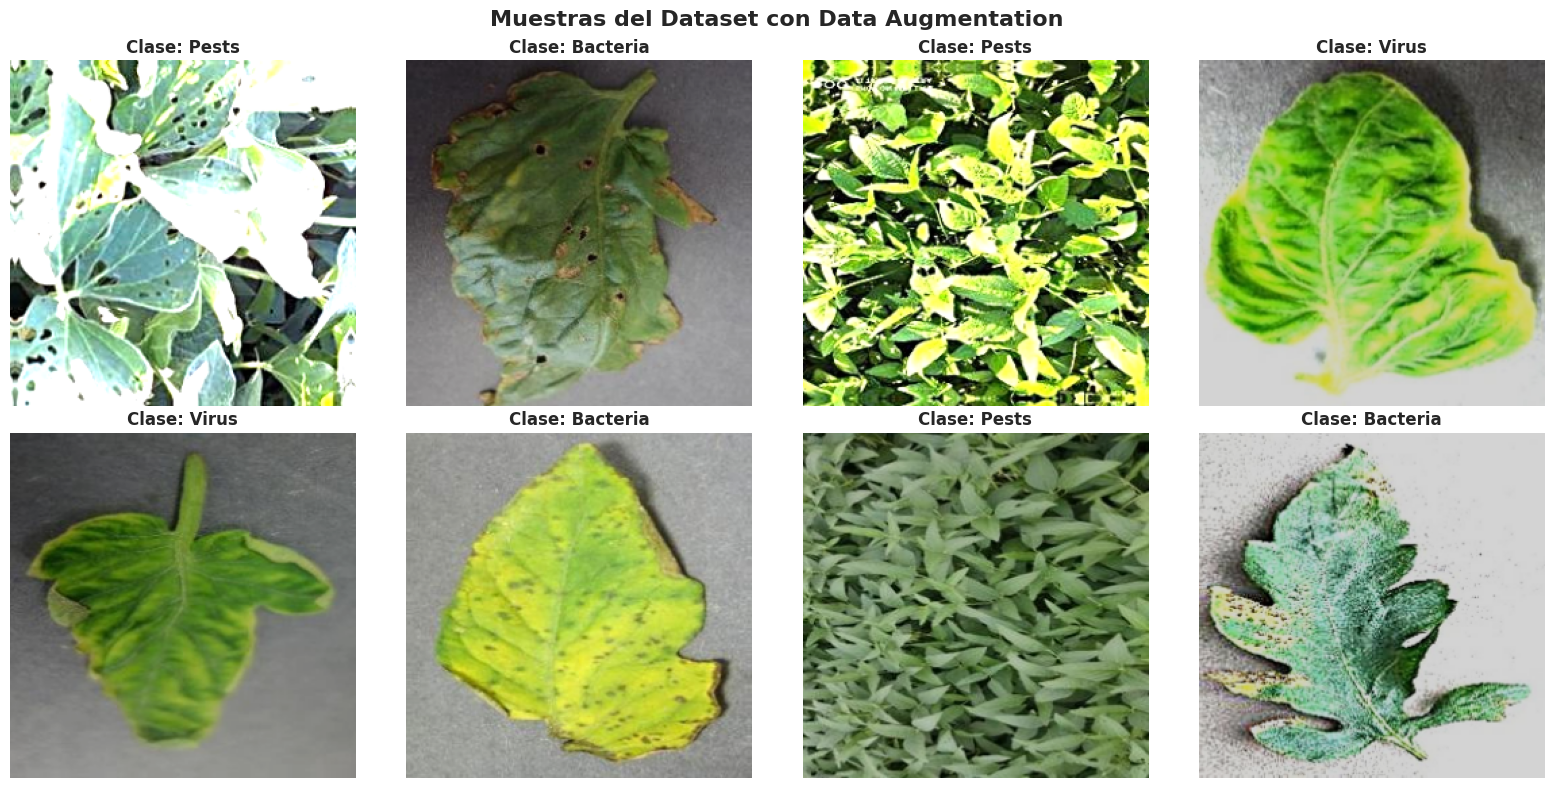

In [22]:
def visualizar_augmentation(generator, num_images=8):
    """
    Visualiza ejemplos de imágenes con data augmentation
    """
    images, labels = next(generator)

    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()

    class_names = list(generator.class_indices.keys())

    for i in range(min(num_images, len(images))):
        axes[i].imshow(images[i])
        label_idx = np.argmax(labels[i])
        axes[i].set_title(f'Clase: {class_names[label_idx]}', fontweight='bold')
        axes[i].axis('off')

    plt.suptitle('Muestras del Dataset con Data Augmentation',
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}/data_augmentation_samples.png', dpi=150, bbox_inches='tight')
    plt.show()

print("Visualizando muestras con data augmentation...")
visualizar_augmentation(train_generator)

#### Creación del modelo CNN

In [23]:
def cnn_pathology_detect(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES):
    """
    Construye una CNN para clasificación de imágenes
    """

    model = models.Sequential(name='CNN_Pathogen_Classifier')

    # BLOQUE CONVOLUCIONAL 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu',
                           padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    #  BLOQUE CONVOLUCIONAL 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    #  BLOQUE CONVOLUCIONAL 3
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    #  BLOQUE CONVOLUCIONAL 4
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.25))

    #  CAPAS FULLY CONNECTED
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))

    #  CAPA DE SALIDA
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

# Crear el modelo
print("Construyendo la arquitectura CNN...")
model = cnn_pathology_detect()

print("\nModelo creado exitosamente!")
print("\nResumen de la arquitectura:")
model.summary()

Construyendo la arquitectura CNN...

Modelo creado exitosamente!

Resumen de la arquitectura:


Model: "CNN_Pathogen_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 34,866,725 (133.01 MB)

 Trainable params: 34,863,269 (132.99 MB)

 Non-trainable params: 3,456 (13.50 KB)

In [24]:
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy',
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall'),
             keras.metrics.AUC(name='auc')]
)

print("Modelo compilado correctamente")
print(f"   Optimizador: Adam (lr={LEARNING_RATE})")
print(f"   Función de pérdida: categorical_crossentropy")
print(f"   Métricas: accuracy, precision, recall, auc")

Modelo compilado correctamente
   Optimizador: Adam (lr=0.001)
   Función de pérdida: categorical_crossentropy
   Métricas: accuracy, precision, recall, auc
